In [13]:
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
import maxr
import h5py

#### Integrating given an explicity velocity function

Define a blinking vortex function

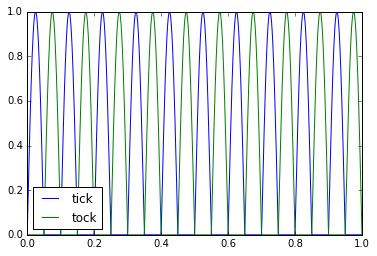

In [21]:
from maxr.flow.blink import tick, tock, blink

period = 0.1
ts = numpy.linspace(0,1,1000)
plt.plot(ts, tick(ts, period), label='tick')
plt.plot(ts, tock(ts, period), label='tock')
plt.legend(loc='best')

In [15]:
flow = blink(gamma=1, period=0.5)

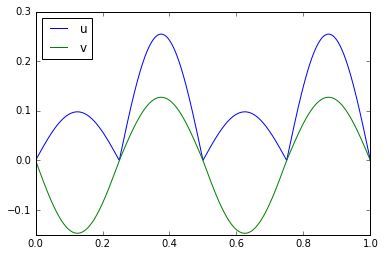

In [16]:
u, v = flow(0.25, 0.5, ts)
plt.plot(ts, u, label='u')
plt.plot(ts, v, label='v')
plt.legend(loc='best')

We need to calculate the velocity divergence and time derivative at given points

#### Integrating given a velocity field from file

Given a velocity field generating function, calculate values from a grid and write out to file

In [17]:
fname = 'blink.hdf5'
maxr.flow.from_function(flow, fname)
flow = maxr.flow.Flow(fname)

Check that everything got made ok

In [18]:
flow.info()

du/dt (40, 40, 20)
du/dx (40, 40, 20)
du/dy (40, 40, 20)
dv/dt (40, 40, 20)
dv/dx (40, 40, 20)
dv/dy (40, 40, 20)
t (20,)
u (40, 40, 20)
v (40, 40, 20)
x (40,)
y (40,)


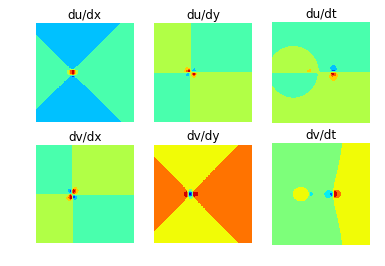

In [19]:
xs, ys = flow.grid() 
f, axes = plt.subplots(2, 3)
for i in (0, 1):
    df = 'dv' if i else 'du'
    for j in (0, 1):
        dx = 'dy' if j else 'dx'
        ax = axes[i, j]
        key = df + '/' + dx
        ax.contourf(xs, ys, flow.data[key][..., 5])
        ax.set_aspect('equal')
        ax.set_axis_off()
        ax.set_title(key)
    
    ax = axes[i, 2]
    key = df + '/dt'
    ax.contourf(xs, ys, flow.data[key][..., 5])
    ax.set_axis_off()
    ax.set_title(key)

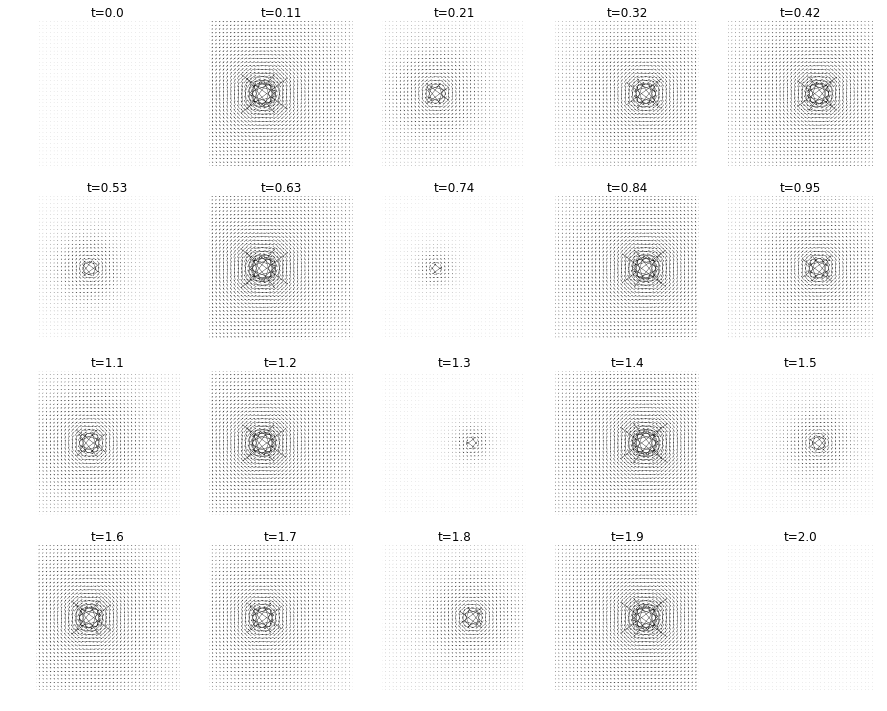

In [20]:
flow.plot_snapshots(plot_every=1)

In [9]:
dudt = f('du/dt')

TypeError: 'Figure' object is not callable

In [10]:
dudt([0.5, 0.5, 0.1])

NameError: name 'dudt' is not defined

In [11]:
def flow_forcing(f, r, w, t, params):
    """ Calculate the instantaneous terms using the flow forcing
    """
    R, S = params.R, params.S
    gx = (p.R - 1) * f('du/dt')(r) - numpy.dot(flow['u'] + w, ) - p.R / p.S * w
    

In [12]:
flow_forcing(
    numpy.array([-0.02, -0.02]), 
    numpy.array([0.02, 0.02]), 
    numpy.array([0, 0]))

TypeError: flow_forcing() missing 2 required positional arguments: 't' and 'params'

In [ ]:
def bashforth_adams(fs, ts):
    """ Integrate a function through time using a Bashforth-Adams method
    """
    